In [1]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.tsa.vector_ar.vecm
import statsmodels.api as sm

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Define your path
path = "/Users/joche/Documents/GitHub/GVAR_modeling/"

# Data preperation

In [33]:
# Import all data for different variables
variable_list_raw = ['GDP', 'CPI','short_int','long_int','exch_rate','CPI_lag']
df_variable_raw = pd.read_excel(path + "Variable_data.xlsx",index_col=0, sheet_name=variable_list_raw)

# To prevent LinAlg errors:
df_variable_raw['exch_rate'].loc["United States"] += np.random.normal(0,0.01,df_variable_raw['exch_rate'].shape[1])

# Make a dictionary for all variables
df_variable = {}

# Transformating the data
df_variable['GDP'] = np.log(df_variable_raw['GDP'])
df_variable['inf_rate'] = np.log(df_variable_raw['CPI']) - np.log(df_variable_raw['CPI_lag'])
df_variable['long_int'] = 1/12 * np.log(1+ df_variable_raw['long_int'])
df_variable['short_int'] = 1/12 * np.log(1+ df_variable_raw['short_int'])
df_variable['exch_rate'] = np.log(df_variable_raw['exch_rate']) - np.log(df_variable_raw['CPI'])

In [43]:
# Define a list of all countries and variables (and a list of extended names for variables for plotting)
# country_list = df_variable['GDP'].index.values
variable_list = np.array(['GDP', 'inf_rate','short_int','long_int','exch_rate'])
country_list = df_variable['inf_rate'].index.values
# variable_list = np.array(['inf_rate','long_int'])
ext_variable_list = ['Real gross domestic product','Inflation rate','Short-term interest rate','Long-term interest rate','Real exchange rate']

# Define an empty dictionary
df = {}

# Loop over all countries and put their variable data in dictionary df
for country in country_list:
    country_collection = []
    
    for variable in variable_list:
        country_collection.append(df_variable[variable].loc[country])
    
    df[country] = pd.DataFrame(country_collection,index=variable_list)

In [35]:
# Example of the data of the United States
df['United States']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,13.702539,13.712432,13.719735,13.725055,13.728973,13.732053,13.734847,13.737903,13.741546,13.745238,...,14.320758,14.320274,14.321086,14.323112,14.325936,14.329066,14.332011,14.334289,14.335419,14.334922
inf_rate,0.005949,0.003243,0.005055,0.003914,0.001951,0.000557,0.001946,0.001943,0.003183,0.003173,...,0.013285,0.005597,0.010951,0.013633,-0.000147,-0.000368,0.002206,0.004032,-0.001025,-0.003081
long_int,0.010751,0.010992,0.011676,0.012210,0.012748,0.012210,0.011929,0.012239,0.011951,0.012225,...,0.008018,0.008026,0.008185,0.008652,0.009011,0.008637,0.008884,0.009168,0.008907,0.008981
short_int,0.004375,0.004185,0.004296,0.004351,0.004351,0.004430,0.004485,0.004383,0.004470,0.004391,...,0.000606,0.000755,0.001101,0.001544,0.002058,0.002269,0.002633,0.003148,0.003636,0.003676
exch_rate,-4.272536,-4.260334,-4.280828,-4.273089,-4.280926,-4.280335,-4.286243,-4.291397,-4.281710,-4.295066,...,-4.901291,-4.874498,-4.886415,-4.924566,-4.911777,-4.925826,-4.902433,-4.931782,-4.916593,-4.911912


# Trade matrix

In [36]:
# Import all trading data
df_trade_raw = pd.read_excel(path + "Trade_statistics.xlsx",index_col=[0,1])

# Get a list of all years (data from 1993 until 2022)
year_list = df_trade_raw.columns

# Define an empty dictionary
df_trade_year = {} 

# Loop over all years and put the trade weights data of that year in dictionary df_trade_year
for year in year_list:
    country_collection = []
    
    for country in country_list:
        country_collection.append(df_trade_raw.loc[country, year] / np.sum(df_trade_raw.loc[country, year]))
    
    df_trade_year[year] = pd.DataFrame(country_collection,index=country_list)

In [24]:
# Example of the trade weights on the year 2000
df_trade_year[1995]

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.008081,0.029534,0.018622,0.028224,0.032035,0.408060,0.149838,0.128363,0.016162,0.007361,0.061261,0.112460
Brazil,0.014308,0.000000,0.022046,0.049668,0.103230,0.081943,0.148355,0.039579,0.002160,0.012481,0.041942,0.063405,0.420883
Canada,0.004478,0.005239,0.000000,0.007410,0.013136,0.007351,0.049235,0.011243,0.000732,0.000910,0.002462,0.015392,0.882412
France,0.008250,0.009110,0.012133,0.000000,0.323878,0.176981,0.036100,0.012710,0.001613,0.006506,0.134842,0.169797,0.108080
Germany,0.016051,0.022073,0.012539,0.257852,0.000000,0.166854,0.057478,0.026723,0.002195,0.017488,0.076384,0.177586,0.166775
Italy,0.011544,0.023712,0.016093,0.228741,0.330302,0.000000,0.039992,0.017209,0.001936,0.008486,0.086525,0.109054,0.126407
Japan,0.036686,0.011765,0.026384,0.027465,0.092028,0.018402,0.000000,0.141661,0.007360,0.011239,0.010845,0.063711,0.552456
Korea,0.026528,0.025676,0.030260,0.025534,0.100819,0.017422,0.288139,0.000000,0.003407,0.007869,0.014319,0.048574,0.411451
New Zealand,0.311008,0.004719,0.025018,0.016249,0.036727,0.021872,0.248519,0.078972,0.000000,0.004751,0.007307,0.092887,0.151971
South Africa,0.030793,0.022389,0.013502,0.060908,0.153811,0.089425,0.112252,0.051549,0.002631,0.000000,0.047589,0.231573,0.183578


In [26]:
# Define the normal trade weight (which is an average of the last three years)
df_trade = (df_trade_year[2020] + df_trade_year[2021] + df_trade_year[2022])/3

# Potentially save this trade matrix
# df_trade.to_excel(path + "saved_values.xlsx")

# Show the chosen trade matrix
df_trade

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.010022,0.014164,0.014274,0.026504,0.005641,0.441705,0.222185,0.073934,0.009536,0.005110,0.056375,0.120548
Brazil,0.008543,0.000000,0.071687,0.038948,0.075050,0.057034,0.078890,0.075848,0.001375,0.018676,0.090158,0.045526,0.438265
Canada,0.004615,0.005053,0.000000,0.007343,0.012802,0.005823,0.027182,0.011281,0.000883,0.000709,0.004001,0.034296,0.886010
France,0.012640,0.014547,0.014707,0.000000,0.294400,0.171517,0.025971,0.021429,0.002044,0.006511,0.155555,0.123540,0.157140
Germany,0.020259,0.021205,0.021493,0.208094,0.000000,0.149398,0.038248,0.039699,0.003107,0.016236,0.087555,0.140103,0.254603
Italy,0.017389,0.017485,0.020209,0.212202,0.264549,0.000000,0.030252,0.022228,0.002558,0.008034,0.103596,0.097037,0.204462
Japan,0.056912,0.014812,0.031543,0.024444,0.075202,0.018230,0.000000,0.196589,0.009996,0.008252,0.009478,0.042028,0.512513
Korea,0.063054,0.026059,0.038088,0.024480,0.059626,0.024464,0.164780,0.000000,0.012672,0.005267,0.015972,0.032019,0.533519
New Zealand,0.325075,0.003974,0.031449,0.018152,0.034132,0.010395,0.148405,0.082339,0.000000,0.007072,0.005665,0.057439,0.275902
South Africa,0.021761,0.010688,0.009855,0.018731,0.237414,0.029517,0.170230,0.053350,0.002074,0.000000,0.035472,0.157845,0.253063


# VARX model

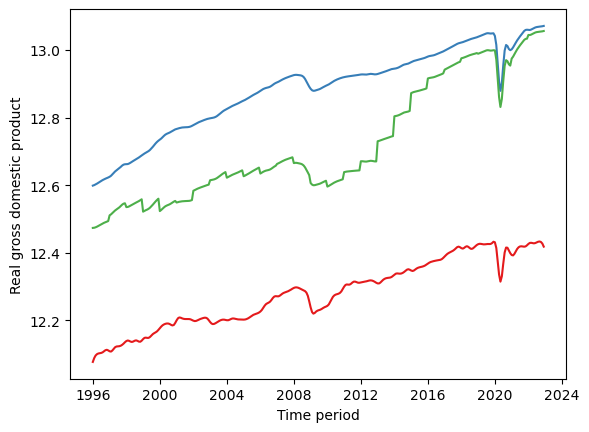

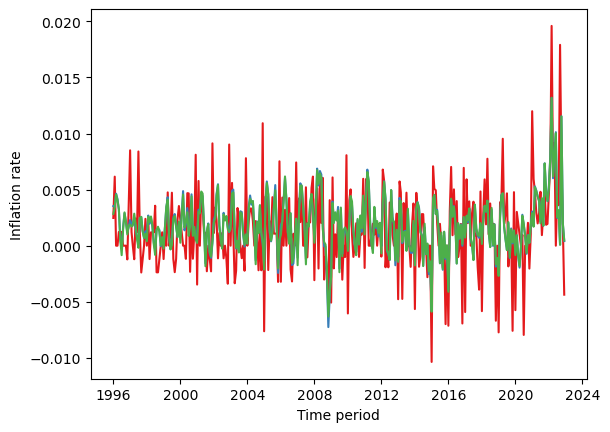

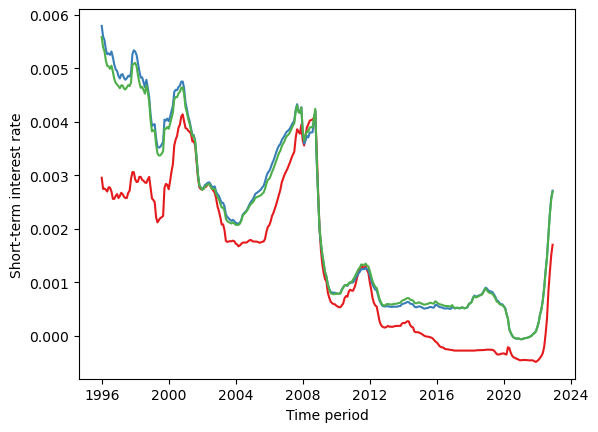

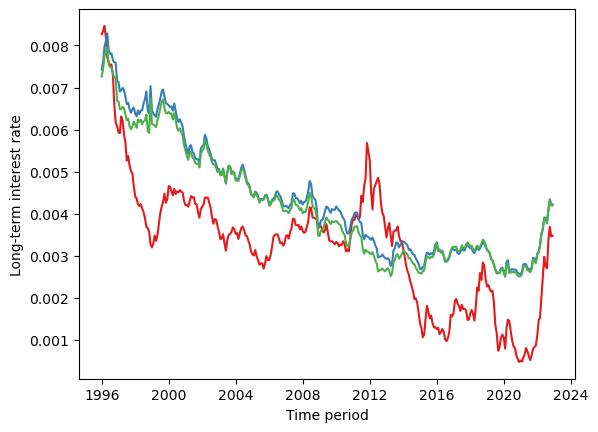

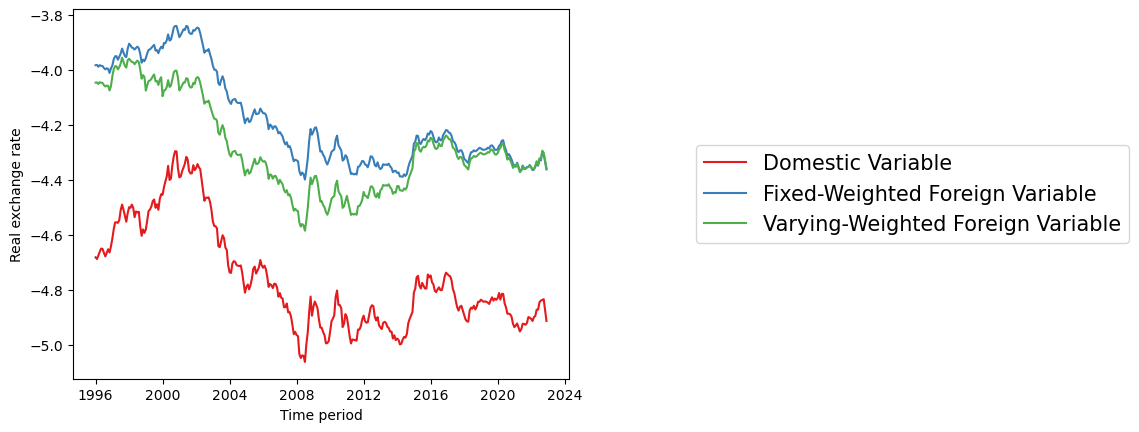

In [95]:
# Define a country
country = 'Germany'

sns.set_palette("Set1")

# Define the x_it and x_star for a country
x_it = df[country].T
x_star_fixed = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
x_star_vary = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])

# Plot x_it and x_star for every variable
for i in range(len(variable_list)-1):

    sns.lineplot(x_it[variable_list[i]])
    sns.lineplot(x_star_fixed[variable_list[i]])
    sns.lineplot(x_star_vary[variable_list[i]])
    
    plt.xlabel("Time period")
    plt.ylabel(ext_variable_list[i])
        
    plt.show()


fig, ax = plt.subplots()

sns.lineplot(x_it[variable_list[4]],label='Domestic Variable')
sns.lineplot(x_star_fixed[variable_list[4]],label='Fixed-Weighted Foreign Variable')
sns.lineplot(x_star_vary[variable_list[4]],label='Varying-Weighted Foreign Variable')
    
plt.xlabel("Time period")
plt.ylabel(ext_variable_list[4])
    
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(2.15, 0.5),prop={'size':15})

plt.show()

# Test order of integration

In [96]:
# Define the DataFrames to fill the results in
adf_test_diff0 = pd.DataFrame(index=variable_list)
adf_test_diff1 = pd.DataFrame(index=variable_list)
adf_test_diff2 = pd.DataFrame(index=variable_list)

# Loop over every country and variable
for country in country_list:
    for variable in variable_list:
        
        # Take the data and its first and second difference
        non_dif = df[country].loc[variable]
        first_dif = np.diff(non_dif)
        second_dif = np.diff(first_dif)
        
        # Fill the DataFrames with the adf test statistics
        adf_test_diff0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif, autolag= 'AIC',regression='ct')[0],4)
        adf_test_diff1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif, autolag= 'AIC',regression='ct')[0],4)
        adf_test_diff2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif, autolag= 'AIC',regression='ct')[0],4)

In [97]:
# Show the results

adf_test_diff0
# adf_test_diff1
# adf_test_diff2

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,-2.1950,-0.9736,-2.8540,-3.0941,-3.4586,-3.0142,-2.8997,-0.0270,-1.6906,0.5585,-2.4617,-2.8364,-3.1084
inf_rate,-2.3123,-8.8337,-3.6022,-2.0847,-1.2658,-0.2414,-2.9236,-4.1758,-3.6978,-4.5160,-3.3969,-1.6271,-4.0391
short_int,-3.0160,-3.1889,-3.0204,-2.5749,-2.5863,-2.3429,-2.0885,-2.6979,-2.1349,-2.8195,-1.9984,-1.5273,-2.7013
long_int,-2.8912,-2.2623,-1.7831,-1.8528,-3.1307,-3.2302,-1.5591,-2.8347,-3.0129,-2.0291,-2.8132,-1.6744,-1.0311
exch_rate,-1.8593,-1.7555,-1.5281,-2.0008,-2.2288,-1.8810,-2.2508,-3.3705,-2.1442,-2.8462,-1.8193,-2.4671,-1.4063


# Determine the lag order

In [98]:
def determine_lag(x_it,x_star,max_lag=8):
    
    # Define the current lowest BIC value
    min_bic = 1000000
    
    # Loop over all possible combinations
    for lag_x_it in range(1,max_lag+1):
        for lag_x_star in range(1,max_lag+1):
            # Initialize a dataframe with the x_star values of lag 0
            df_country = pd.concat([x_star])
            df_country.columns += "_L0"
    
            # Loop over all lag_x_it values to add the lagged values of x_it to df_country
            for lag in range(1,lag_x_it+1):
                lagged_x_it = x_it.shift(lag)
                lagged_x_it.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
            # Loop over all lag_x_star values to add the lagged values of x_star to df_country
            for lag in range(1,lag_x_star+1):
                lagged_x_star = x_star.shift(lag)
                lagged_x_star.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
            # Create and fit the model
            model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
            results = model.fit(maxlags=0,trend='ct')
            
            # Determine the BIC value
            results_bic = -2 * results.llf / 5 + (2 + 5 * (lag_x_it+lag_x_star+1)) * np.log(324)
            
            # Update the lag and BIC value if the BIC value is smaller
            if (results_bic < min_bic):
                min_bic = results_bic
                best_lag_bic = (lag_x_it,lag_x_star)
    
    return best_lag_bic, min_bic

In [99]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"

    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=8)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 4)
The BIC value is -3652.9123107436094

For Brazil
The lag order by BIC is (4, 4)
The BIC value is -2968.8157292878905

For Canada
The lag order by BIC is (4, 4)
The BIC value is -3460.3467642890582

For France
The lag order by BIC is (4, 4)
The BIC value is -3808.947319388433

For Germany
The lag order by BIC is (4, 4)
The BIC value is -3535.2116740308925

For Italy
The lag order by BIC is (4, 4)
The BIC value is -3730.3420885895875

For Japan
The lag order by BIC is (4, 1)
The BIC value is -3455.312540849996

For Korea
The lag order by BIC is (4, 1)
The BIC value is -3250.22625665379

For New Zealand
The lag order by BIC is (4, 4)
The BIC value is -3563.6001408262446

For South Africa
The lag order by BIC is (3, 3)
The BIC value is -3149.8792135484223

For Spain
The lag order by BIC is (4, 4)
The BIC value is -3735.5433330144447

For United Kingdom
The lag order by BIC is (4, 4)
The BIC value is -3264.43252688674

For United States
The lag o

In [100]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with varying trade weights
    x_star = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=8)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 1)
The BIC value is -3642.0959242460267

For Brazil
The lag order by BIC is (4, 1)
The BIC value is -2957.6344204795146

For Canada
The lag order by BIC is (4, 1)
The BIC value is -3407.2740863171625

For France
The lag order by BIC is (4, 1)
The BIC value is -3651.888151199929

For Germany
The lag order by BIC is (4, 1)
The BIC value is -3479.751994831238

For Italy
The lag order by BIC is (4, 1)
The BIC value is -3562.5132147203904

For Japan
The lag order by BIC is (4, 1)
The BIC value is -3438.944798170388

For Korea
The lag order by BIC is (4, 1)
The BIC value is -3255.110078073696

For New Zealand
The lag order by BIC is (4, 1)
The BIC value is -3532.0859591779445

For South Africa
The lag order by BIC is (4, 1)
The BIC value is -3053.4195298999866

For Spain
The lag order by BIC is (4, 1)
The BIC value is -3533.9971250152385

For United Kingdom
The lag order by BIC is (4, 1)
The BIC value is -3151.6884576101193

For United States
The lag

# Checking weights

In [101]:
def fit_model(x_it,x_star,lag_x_it,lag_x_star):
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([x_star])
    df_country.columns += "_L0"
    
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        lagged_x_it = x_it.shift(lag)
        lagged_x_it.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_it], axis=1)
                
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        lagged_x_star = x_star.shift(lag)
        lagged_x_star.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
    # Create and fit the model
    model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct')
    
    return results

In [102]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define a DataFrame for the R_squared
df_Rsquared_fixed = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared_fixed.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [103]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define a DataFrame for the R_squared
df_Rsquared_vary = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:

    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)
    
    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared_vary.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [104]:
# Full DataFrame of R^2's
# df_Rsquared_fixed

# Mean of R^2's
np.mean(df_Rsquared_fixed,axis=1) 

GDP          0.999972
inf_rate     0.621665
short_int    0.993301
long_int     0.989948
exch_rate    0.991683
dtype: float64

In [106]:
# Full DataFrame of R^2's
# df_Rsquared_vary

# Mean of R^2's
np.mean(df_Rsquared_vary,axis=1) 

GDP          0.999764
inf_rate     0.618566
short_int    0.993423
long_int     0.989757
exch_rate    0.991353
dtype: float64

# Fitting the model

In [107]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define two dictionaries for the parameter estimates and residuals
df_estimates = {}
resid_dict = {}

# Loop over all countries
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params[x_it.columns.tolist()].T

    # Fill the residuals of the VARX model in the dictionary
    resid_dict[country] = results.resid

In [109]:
# Example of the VARX estimates of Australia
df_estimates['United States']

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,short_int_x_star_L0,long_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L1,inf_rate_x_it_L1,short_int_x_it_L1,...,GDP_x_star_L3,inf_rate_x_star_L3,short_int_x_star_L3,long_int_x_star_L3,exch_rate_x_star_L3,GDP_x_star_L4,inf_rate_x_star_L4,short_int_x_star_L4,long_int_x_star_L4,exch_rate_x_star_L4
GDP_x_it,0.058381,0.000011,0.765478,-0.003689,0.294406,0.059041,-0.003029,2.972013,-0.004337,-0.156450,...,-1.836892,0.003596,0.014617,-0.323530,-0.002296,0.489770,0.025818,0.022766,0.179567,0.000661
inf_rate_x_it,0.166789,0.000063,-0.111972,1.060318,-0.380286,1.373001,-0.023593,-0.299274,0.024656,0.361628,...,0.666739,0.166325,-1.673616,-0.455806,-0.008327,-0.173520,0.292130,1.198099,0.157622,0.012471
short_int_x_it,-0.001757,0.000001,0.006648,0.003958,0.537734,-0.007053,0.002145,0.030394,0.007111,1.234968,...,-0.027809,-0.000162,0.271689,-0.172566,-0.000448,0.005938,-0.000641,-0.085026,0.019684,0.000171
long_int_x_it,0.076890,0.000018,-0.037981,0.012813,0.472753,0.509653,0.002699,-0.007170,0.013660,0.296465,...,0.093732,-0.019760,-0.696240,-0.145393,-0.000365,-0.039047,0.002327,0.301580,0.151027,0.000607
exch_rate_x_it,0.006170,-0.000403,-0.340769,-0.275603,2.780740,-9.005294,0.037798,0.930793,-0.338719,4.274692,...,-0.940032,-0.699748,8.352858,-0.429286,-0.165068,0.433290,-0.760634,-5.637292,1.086395,0.133152


# Stacking the GVAR model

In [110]:
# Defining lengths k_i, k_star and k:
k_i = k_star = len(variable_list)
k = len(variable_list) * len(country_list)

# Stack all a_i0 parameters
matrix_col = []
for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"const"])
a_0 = pd.concat(matrix_col)

# Stack all a_i1 parameters
matrix_col = []

for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"trend"])
a_1 = pd.concat(matrix_col)

# Stack all residuals
epsilon_t = pd.concat(resid_dict.values(), axis=1).T

In [111]:
def create_G_j(j):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        # Create Omega_i
        i = np.where(country_list == country)[0][0]
        E_i = np.hstack((np.zeros((k_i, i * k_i)), np.eye(k_i), np.zeros((k_i, (13-i-1) * k_i))))
        W_i = np.hstack([foreign_trade * np.eye(k_star) for foreign_trade in df_trade.loc[country]])
        Omega_i = np.vstack((E_i,W_i))
        
        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i),-lambda_i))
        else:
            
            if (lag_x_it < j):
                phi_i = np.zeros((k_i,k_i))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_it_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]
                
            if (lag_x_star < j):
                lambda_i = np.zeros((k_i,k_star))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
                
            A_i = np.hstack((phi_i,lambda_i))
        
        # Finally, compute G_i by A_i and Omega_i
        G_i = A_i @ Omega_i
        matrix_col.append(G_i)

    # Return G_j
    return np.vstack(matrix_col)

In [112]:
# To show that this method works, we compute the residuals by matrices G:

# Create matrices G_j
G_0 = create_G_j(j=0)
G_1 = create_G_j(j=1)
G_2 = create_G_j(j=2)
G_3 = create_G_j(j=3)
G_4 = create_G_j(j=4)

# Function to get the x_t of time t and lag l
def x_t(l,t): 
    return pd.concat([df[country].T for country in country_list],axis=1).T.iloc[:,max_lag+t-l]

# Set time t between 0 and 319
t = 0

# The residuals of time t are the same as of the ones from the VARX* models
print(G_0 @ x_t(0,t) - a_0 - a_1 * (t+1) - G_1 @ x_t(1,t) -  G_2 @ x_t(2,t) - G_3 @ x_t(3,t) -  G_4 @ x_t(4,t))

GDP_x_it         -0.000053
inf_rate_x_it    -0.000776
short_int_x_it   -0.000050
long_int_x_it     0.000063
exch_rate_x_it   -0.012802
                    ...   
GDP_x_it         -0.000758
inf_rate_x_it    -0.002751
short_int_x_it    0.000033
long_int_x_it     0.000088
exch_rate_x_it    0.003111
Length: 65, dtype: float64


In [113]:
# Compare it with the residuals from the regression
epsilon_t

,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,1997-02-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP_x_it,-0.000053,-0.000162,-0.000203,-0.000610,-0.000584,-0.000536,-0.000983,-0.000769,0.000614,0.000903,...,-0.000659,-0.000856,0.000240,0.000296,0.000281,0.000073,0.000005,-0.000052,-0.000525,-0.000382
inf_rate_x_it,-0.000776,-0.000150,-0.000180,0.000066,-0.000260,-0.000183,0.000165,0.000436,-0.000077,0.000133,...,-0.000220,0.000648,0.000026,0.000418,-0.000110,0.000074,0.000093,-0.000290,0.000162,0.000300
short_int_x_it,-0.000050,0.000017,0.000090,-0.000448,0.000248,-0.000094,0.000037,-0.000097,-0.000020,0.000199,...,-0.000072,-0.000037,0.000204,0.000261,0.000142,-0.000038,0.000183,-0.000028,0.000037,-0.000010
long_int_x_it,0.000063,0.000252,-0.000146,-0.000250,0.000107,-0.000169,-0.000101,0.000303,0.000131,0.000065,...,0.000052,0.000037,0.000185,0.000149,-0.000135,0.000134,0.000028,0.000146,0.000052,-0.000033
exch_rate_x_it,-0.012802,-0.008444,0.004820,0.007362,-0.015006,-0.002621,-0.022614,-0.025849,-0.003261,-0.028319,...,-0.020885,-0.012833,0.027057,-0.021997,0.001578,-0.025155,-0.008606,-0.004566,-0.032794,0.000614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GDP_x_it,-0.000758,-0.000528,-0.000385,-0.000069,-0.000024,-0.000263,-0.000165,-0.000187,0.000382,0.000335,...,-0.000651,-0.000103,0.000189,0.000616,0.000302,0.000402,0.000756,0.000120,-0.000056,-0.000487
inf_rate_x_it,-0.002751,-0.001115,0.000780,0.000453,0.001330,0.001469,0.000069,-0.001861,-0.000568,0.001063,...,-0.001247,-0.004601,0.001920,0.004516,-0.001673,0.002661,0.003149,-0.001624,-0.001731,0.001255
short_int_x_it,0.000033,-0.000031,0.000063,-0.000186,0.000201,0.000028,0.000083,0.000082,0.000163,0.000012,...,0.000139,-0.000126,0.000132,0.000078,0.000063,-0.000030,-0.000016,0.000160,0.000252,-0.000159
long_int_x_it,0.000088,-0.000659,-0.000227,0.000003,-0.000285,0.000265,0.000086,-0.000019,-0.000103,-0.000575,...,0.000186,-0.000320,0.000129,0.000129,0.000142,-0.000203,0.000034,-0.000148,-0.000002,0.000267


In [114]:
# Calculate the inverse of G_0
G_0_inv = np.linalg.inv(create_G_j(j=0))

# Create a dictionary for the values of F_l
F_l_dict = {}

# Fill dictionary by computing the values of F_l 
for j in range(max_lag+1):
    F_l_dict[j] = G_0_inv @ create_G_j(j=j)

# GIRF

In [115]:
# Method to compute R_h for a given h
def calculate_R_h(h, memo={}):
    if h in memo:
        return memo[h]

    if h < 0:
        memo[h] = np.zeros((k,k))
    elif h == 0:
        memo[h] = np.eye(k)
    else:
        memo[h] = sum([F_l_dict[l] @ calculate_R_h(h-l) for l in range(1,max_lag+1)])
    
    return memo[h]

In [119]:
def perform_GIRF(max_h,country_shock,variable_shock,country_choice,variable_choice):
    
    # Get the index of the country and variable of the shock and define e_j
    country_i = np.where(country_list == country_shock)[0][0]
    variable_i = np.where(variable_list == variable_shock)[0][0]
    e_j = np.zeros((k,1))
    e_j[country_i * k_i + variable_i] = 1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Initialize an empty array for the index and names of the chosen countries and variables
    index_array = []
    name_array = []
    
    # Loop over all chosen countries and variables and append to arrays
    for country in country_choice:
        country_i = np.where(country_list == country)[0][0]
        variable_i = np.where(variable_list == variable_choice)[0][0]
        index_array.append(country_i * k_i + variable_i)
        name_array.append(country)
    
    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])
    
    # Make a dictionary for the specific country color and line kind
    country_color = {}
    country_line = {}
    for i in range(len(country_list)):
        country_color[country_list[i]] = ['#ff7f00','#377eb8','#377eb8', '#4daf4a', '#4daf4a', '#4daf4a','#984ea3','#984ea3', '#ff7f00', '#e41a1c', '#4daf4a',  '#4daf4a','#377eb8'][i]
        country_line[country_list[i]] = ['-','-','--','-','--',':','-','--','--','-','-.',(0, (5, 1)),':'][i]
    
    # Plot all GIRF in a plot
    for i in range(len(index_array)):
        sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]], color=country_color[name_array[i]],linestyle=country_line[name_array[i]],label=name_array[i])
    plt.plot()

# Choose shock:
Countries: ['Australia' 'Brazil' 'Canada' 'France' 'Germany' 'Italy' 'Japan' 'Korea'
 'New Zealand' 'South Africa' 'Spain' 'United Kingdom' 'United States']
 
Variable: ['GDP', 'inf_rate', 'long_int', 'short_int', 'exch_rate']

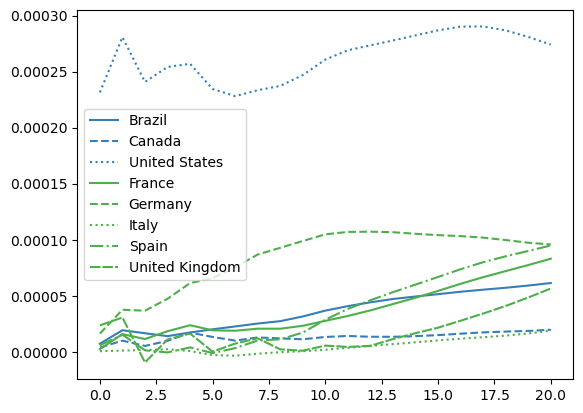

In [134]:
# Define the country and variable of the shock
country_shock = "United States"
variable_shock = 'long_int'

# Define the countries and variables that should be in the IRF
new_country_list = np.array(['Brazil','Canada','United States','France','Germany','Italy','Spain','United Kingdom'])
country_choice = new_country_list
variable_choice = np.array(["long_int"])

# Define the length of h
max_h = 20

perform_GIRF(max_h,country_shock,variable_shock,country_choice,variable_choice)

# Period analysis

In [130]:
periods = 324
interval = np.arange(0,periods+1,periods / 2)

period_df = {}

for country in country_list:
    period_df[country] = df[country].iloc[:,int(interval[0]):int(interval[1])]

# Determine the lag order of a period

In [131]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = period_df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(period_df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=7)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 1)
The BIC value is -1739.1282166784354

For Brazil
The lag order by BIC is (4, 1)
The BIC value is -1394.0657192644885

For Canada
The lag order by BIC is (4, 1)
The BIC value is -1681.7092078414812

For France
The lag order by BIC is (4, 1)
The BIC value is -1864.6143055799373

For Germany
The lag order by BIC is (4, 1)
The BIC value is -1716.5862039773465

For Italy
The lag order by BIC is (4, 1)
The BIC value is -1794.9023457077758

For Japan
The lag order by BIC is (3, 1)
The BIC value is -1617.793818383179

For Korea
The lag order by BIC is (4, 1)
The BIC value is -1486.6032324090186

For New Zealand
The lag order by BIC is (4, 1)
The BIC value is -1722.2925703203573

For South Africa
The lag order by BIC is (4, 1)
The BIC value is -1541.2471969202722

For Spain
The lag order by BIC is (3, 1)
The BIC value is -1835.221019863717

For United Kingdom
The lag order by BIC is (4, 1)
The BIC value is -1595.721284856595

For United States
The la

# Get GIRF

In [141]:
def create_G_j(j,df_estimates,lag_x_it,lag_x_star):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        # Create Omega_i
        i = np.where(country_list == country)[0][0]
        E_i = np.hstack((np.zeros((k_i, i * k_i)), np.eye(k_i), np.zeros((k_i, (13-i-1) * k_i))))
        W_i = np.hstack([foreign_trade * np.eye(k_star) for foreign_trade in df_trade.loc[country]])
        Omega_i = np.vstack((E_i,W_i))
        
        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i),-lambda_i))
        else:
            
            if (lag_x_it < j):
                phi_i = np.zeros((k_i,k_i))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_it_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]

            if (lag_x_star < j):
                lambda_i = np.zeros((k_i,k_star))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
            
            A_i = np.hstack((phi_i,lambda_i))
            
        # Finally, compute G_i by A_i and Omega_i
        G_i = A_i @ Omega_i
        matrix_col.append(G_i)
    
    # Return G_j
    return np.vstack(matrix_col)

# Method to compute R_h for a given h
def calculate_R_h(h, memo={}):
    if h in memo:
        return memo[h]

    if h < 0:
        memo[h] = np.zeros((k,k))
    elif h == 0:
        memo[h] = np.eye(k)
    else:
        memo[h] = sum([F_l_dict[l] @ calculate_R_h(h-l) for l in range(1,max_lag+1)])
    
    return memo[h]    
    

def perform_quick_GIRF(period_df,lag_x_it,lag_x_star,max_h,country_shock,variable_shock,country_choice,variable_choice):
    max_lag = max(lag_x_it,lag_x_star)

    # Define two dictionaries for the parameter estimates and residuals
    df_estimates = {}
    resid_dict = {}

    # Loop over all countries
    for country in country_list:
    
        # Define x_it
        x_it = period_df[country].T
        x_it.index.freq = 'MS'
        x_it.columns = x_it.columns + "_x_it"
    
        # Define x_star with fixed trade weights
        x_star = sum(period_df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
        x_star.index.freq = 'MS'
        x_star.columns = x_star.columns + "_x_star"
    
        # Create and fit the model
        results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

        # Fill the parameter estimates of the VARX model in the dictionary
        df_estimates[country] = results.params[x_it.columns.tolist()].T

        # Fill the residuals of the VARX model in the dictionary
        resid_dict[country] = results.resid
    
    # Defining lengths k_i, k_star and k:
    k_i = k_star = len(variable_list)
    k = len(variable_list) * len(country_list)

    # Stack all a_i0 parameters
    matrix_col = []
    for country in country_list:
        matrix_col.append(df_estimates[country].loc[:,"const"])
    a_0 = pd.concat(matrix_col)

    # Stack all a_i1 parameters
    matrix_col = []

    for country in country_list:
        matrix_col.append(df_estimates[country].loc[:,"trend"])
    a_1 = pd.concat(matrix_col)

    # Stack all residuals
    epsilon_t = pd.concat(resid_dict.values(), axis=1).T

    # Calculate the inverse of G_0
    G_0_inv = np.linalg.inv(create_G_j(0,df_estimates,lag_x_it,lag_x_star))

    # Create a dictionary for the values of F_l
    F_l_dict = {}

    # Fill dictionary by computing the values of F_l 
    for j in range(max_lag+1):
        F_l_dict[j] = G_0_inv @ create_G_j(j,df_estimates,lag_x_it,lag_x_star)
        
    # Get the index of the country and variable of the shock and define e_j
    country_i = np.where(country_list == country_shock)[0][0]
    variable_i = np.where(variable_list == variable_shock)[0][0]
    e_j = np.zeros((k,1))
    e_j[country_i * 5 + variable_i] = -1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Initialize an empty array for the index and names of the chosen countries and variables
    index_array = []
    name_array = []
    
    # Loop over all chosen countries and variables and append to arrays
    for country in country_choice:
        country_i = np.where(country_list == country)[0][0]
        variable_i = np.where(variable_list == variable_choice)[0][0]
        index_array.append(country_i * k_i + variable_i)
        name_array.append(country)
    
    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])
    
    # Make a dictionary for the specific country color and line kind
    country_color = {}
    country_line = {}
    
    for i in range(len(country_list)):
        country_color[country_list[i]] = ['#ff7f00','#377eb8','#377eb8', '#4daf4a', '#4daf4a', '#4daf4a','#984ea3','#984ea3', '#ff7f00', '#e41a1c', '#4daf4a',  '#4daf4a','#377eb8'][i]
        country_line[country_list[i]] = ['-','-','--','-','--',':','-','--','--','-','-.',(0, (5, 1)),':'][i]
    
    # Plot all GIRF in a plot
    for i in range(len(index_array)):
        sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]], color=country_color[name_array[i]],linestyle=country_line[name_array[i]],label=name_array[i])
    plt.plot()

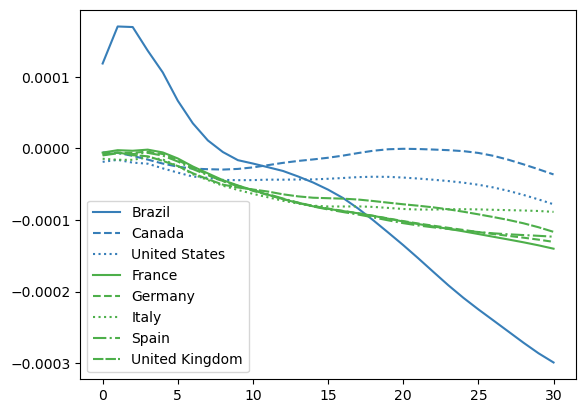

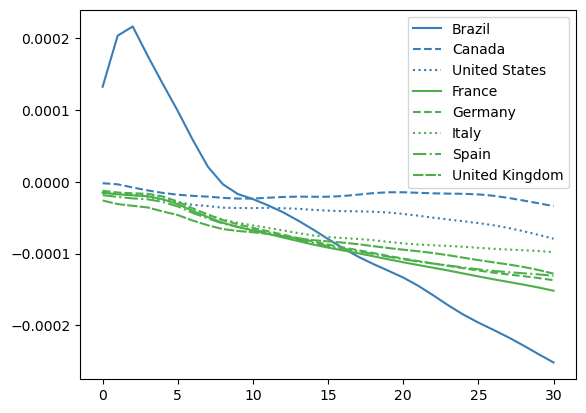

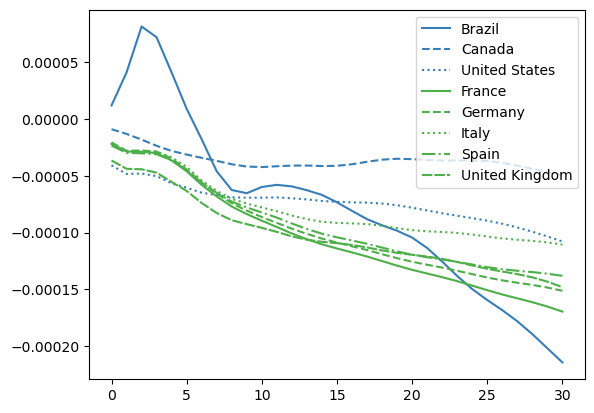

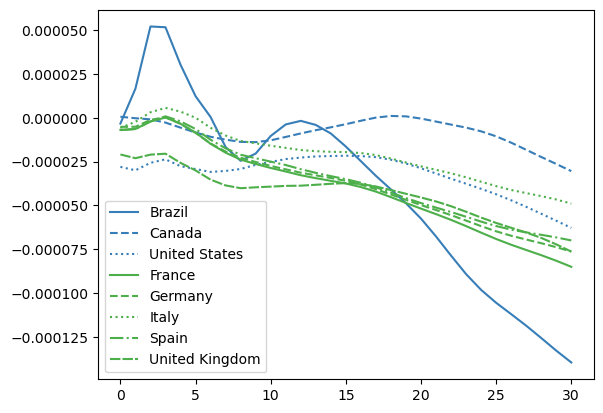

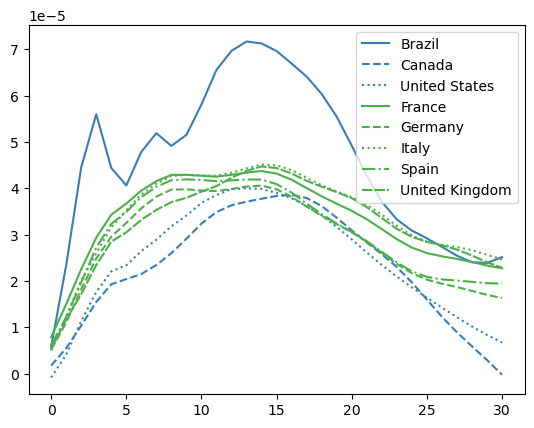

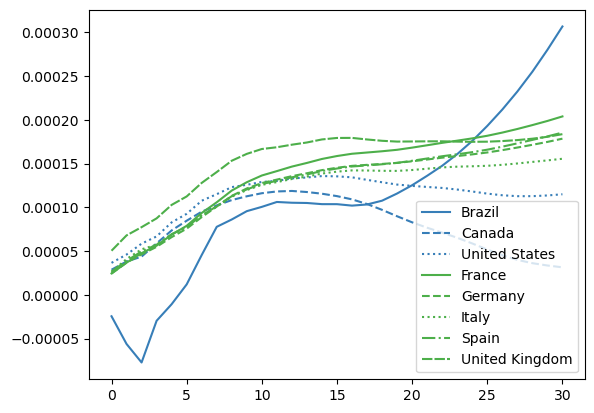

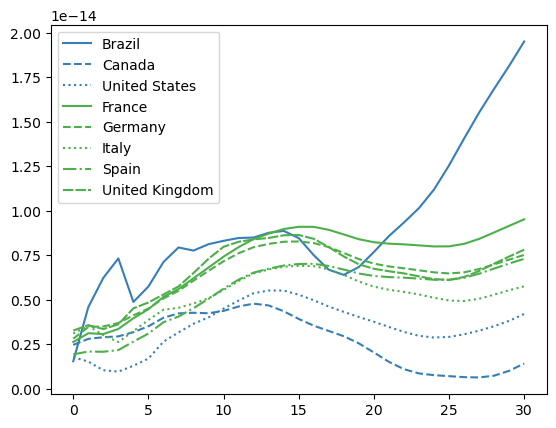

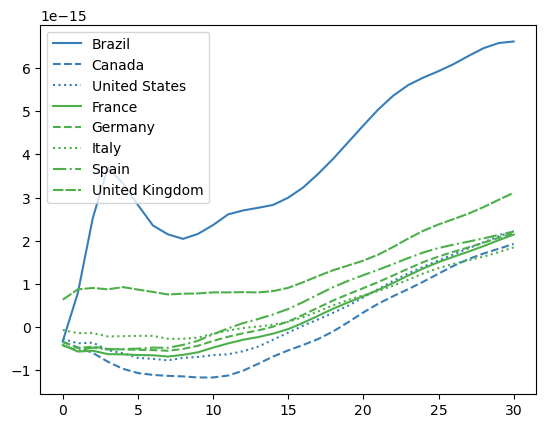

In [155]:
for j in np.arange(0,160,20):
    periods = 324
    interval = np.arange(0,periods+1,periods / 2)

    period_df = {}
    period = 0

    for country in country_list:
        period_df[country] = df[country].iloc[:,int(interval[period]+j):int(interval[period+1])]

    # Define the data and chosen lags
    lag_x_it = 4
    lag_x_star = 4

    # Define the country and variable of the shock
    country_shock = "Japan"
    variable_shock = 'short_int'

    # Define the countries and variables that should be in the IRF
    country_choice = new_country_list#np.array(["France","Germany","Italy"])
    variable_choice = np.array(["short_int"])

    # Define the length of h
    max_h = 30

    perform_quick_GIRF(period_df,lag_x_it,lag_x_star,max_h,country_shock,variable_shock,country_choice,variable_choice)
    plt.show()

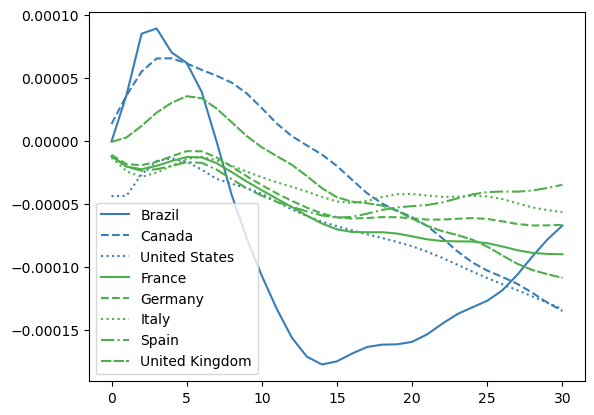

In [150]:
periods = 324
interval = np.arange(0,periods+1,periods / 2)

period_df = {}
period = 1

for country in country_list:
    period_df[country] = df[country].iloc[:,int(interval[period]):int(interval[period+1])]

# Define the data and chosen lags
lag_x_it = 4
lag_x_star = 4

# Define the country and variable of the shock
country_shock = "United States"
variable_shock = 'short_int'

# Define the countries and variables that should be in the IRF
country_choice = new_country_list#np.array(["France","Germany","Italy"])
variable_choice = np.array(["short_int"])

# Define the length of h
max_h = 30

perform_quick_GIRF(period_df,lag_x_it,lag_x_star,max_h,country_shock,variable_shock,country_choice,variable_choice)

# VECM

In [73]:
def perform_VECM(period_df,country_choice,dep_variable_choice,ind_variable_choice):
    # Define the chosen lag
    lag_x_it = 4
    lag_x_star = 4
    max_lag = max(lag_x_it,lag_x_star)

    # Define x_it
    x_it = period_df[country_choice].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(period_df[foreign_country].T * df_trade.loc[country_choice][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)],axis=1)
    df_country.columns += "_L1"
    
    x_star_diff = x_star.diff(1)
    x_star_diff.columns += "_diff_L0" 
    df_country = pd.concat([df_country,x_star_diff], axis=1)

    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,max_lag+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = x_it.diff(1).shift(lag)
            lagged_x_it.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_it], axis=1)
        
        if (lag <= lag_x_star-1):
            lagged_x_star = x_star.diff(1).shift(lag)
            lagged_x_star.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_star], axis=1)
    # Create and fit the model
    model = VAR(endog = x_it.diff(1).iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')
    
    return results.params.T#[ind_variable_choice][dep_variable_choice]

Variable choices: ['GDP_x_it_L1', 'inf_rate_x_it_L1', 'long_int_x_it_L1',
       'short_int_x_it_L1', 'exch_rate_x_it_L1', 'GDP_x_star_L1',
       'inf_rate_x_star_L1', 'long_int_x_star_L1', 'short_int_x_star_L1',
       'exch_rate_x_star_L1', 'GDP_x_star_diff_L0', 'inf_rate_x_star_diff_L0',
       'long_int_x_star_diff_L0', 'short_int_x_star_diff_L0',
       'exch_rate_x_star_diff_L0', 'GDP_x_it_diff_L1', 'inf_rate_x_it_diff_L1',
       'long_int_x_it_diff_L1', 'short_int_x_it_diff_L1',
       'exch_rate_x_it_diff_L1', 'GDP_x_it_diff_L2', 'inf_rate_x_it_diff_L2',
       'long_int_x_it_diff_L2', 'short_int_x_it_diff_L2',
       'exch_rate_x_it_diff_L2', 'GDP_x_it_diff_L3', 'inf_rate_x_it_diff_L3',
       'long_int_x_it_diff_L3', 'short_int_x_it_diff_L3',
       'exch_rate_x_it_diff_L3']

In [227]:
periods = 324
period_len = 108
steps = 6

period_df = {}
time = 0

country_choice = "United States"
dep_variable_choice = "exch_rate_x_it"
ind_variable_choice = "exch_rate_x_star_diff_L0"


params = []
year = []

# for time in np.arange(0,periods-period_len,steps):
# #     print(time)
#     for country in country_list:
#         period_df[country] = df[country].iloc[:,time:period_len+time]
    
#     year.append(period_df[country].columns[-1])
    
# params.append(perform_VECM(df,country_choice,dep_variable_choice,ind_variable_choice))
    
# sns.lineplot(x=year,y=params)
# plt.show()
aaa = perform_VECM(df,country_choice,dep_variable_choice,ind_variable_choice)
selected_cols = [col for col in aaa.columns if col.startswith("GDP")]
aaa.loc[:,selected_cols]

,GDP_x_it_L1,GDP_x_star_L1,GDP_x_star_diff_L0,GDP_x_it_diff_L1,GDP_x_star_diff_L1,GDP_x_it_diff_L2,GDP_x_star_diff_L2,GDP_x_it_diff_L3,GDP_x_star_diff_L3
GDP_x_it,0.072641,-0.068469,0.879570,2.429433,-2.090982,-2.355453,1.915317,1.003201,-0.757514
inf_rate_x_it,-0.067606,0.067063,-0.108668,-0.452989,0.569764,0.569600,-0.551945,-0.339442,0.257232
long_int_x_it,-0.000286,0.004058,-0.036274,-0.002506,0.056648,0.011800,-0.040794,-0.027792,0.030807
short_int_x_it,-0.002250,0.002091,0.003855,0.029063,-0.021312,-0.022731,0.013876,0.007157,-0.000034
exch_rate_x_it,-0.107751,0.075390,0.801755,1.247109,-2.998596,-2.021203,3.783661,0.869240,-1.419970


In [222]:
selected_cols = [col for col in df_estimates[country].columns if col.startswith("GDP")]
print(df_estimates['United States'].loc[:,selected_cols])

                GDP_x_star_L0  GDP_x_it_L1  GDP_x_it_L2  GDP_x_it_L3  \
GDP_x_it             0.879570     3.356793    -4.784886     3.358654   
inf_rate_x_it       -0.108668    -0.385384     1.022589    -0.909041   
long_int_x_it       -0.036274    -0.002219     0.014305    -0.039592   
short_int_x_it       0.003855     0.031313    -0.051794     0.029887   
exch_rate_x_it       0.801755     1.354860    -3.268312     2.890443   

                GDP_x_it_L4  GDP_x_star_L1  GDP_x_star_L2  GDP_x_star_L3  \
GDP_x_it          -1.003201      -2.902082       4.006299      -2.672831   
inf_rate_x_it      0.339442       0.611369      -1.121709       0.809177   
long_int_x_it      0.027792       0.088864      -0.097442       0.071600   
short_int_x_it    -0.007157      -0.027258       0.035188      -0.013910   
exch_rate_x_it    -0.869240      -3.875741       6.782257      -5.203631   

                GDP_x_star_L4  
GDP_x_it             0.757514  
inf_rate_x_it       -0.257232  
long_int_x_it 

In [405]:
perform_VECM(df)['GDP_x_star_diff_L0']

GDP_x_it          0.216366
inf_rate_x_it     0.043116
long_int_x_it    -0.018265
short_int_x_it   -0.003471
exch_rate_x_it   -0.486836
Name: GDP_x_star_diff_L0, dtype: float64

In [68]:
df_estimates = {}
resid_dict = {}

for country in country_list:
    # Define the chosen lag
    lag_x_it = 2
    lag_x_star = 2
    max_lag = max(lag_x_it,lag_x_star)

    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    x_it_star = pd.concat([x_it,x_star],axis=1)
    
    rank = statsmodels.tsa.vector_ar.vecm.select_coint_rank(x_it_star,det_order=-1,k_ar_diff=max_lag-1).rank
    
    
    coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= x_it,exog=x_star,exog_coint=x_star,k_ar_diff=max_lag-1,coint_rank=rank).fit()
#     print()
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)], axis=1) @ np.vstack([coin_result.beta,coin_result.det_coef_coint])
    df_country.columns = ["x_it_star_" + str(i) for i in range(coin_result.beta.shape[1])]
    
    x_star_diff = x_star.diff(1)
    x_star_diff.columns += "_diff_L0" 
    df_country = pd.concat([df_country,x_star_diff], axis=1)

    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,max_lag+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = x_it.diff(1).shift(lag)
            lagged_x_it.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_it], axis=1)
        
        if (lag <= lag_x_star-1):
            lagged_x_star = x_star.diff(1).shift(lag)
            lagged_x_star.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
#     print(df_country)
    
    # Create and fit the model
    model = VAR(endog = x_it.diff(1).iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')

    selected_cols = [col for col in results.params.T.columns if col.endswith("r_diff_L0")]
    matrix = results.params.T.loc[:,selected_cols]
#     print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))

    df_estimate =  results.params.T.loc[:,["const","trend"]]

    selected_cols = [col for col in results.params.T.columns if col.endswith("L0")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = ['GDP_x_star_L0', 'inf_rate_x_star_L0','long_int_x_star_L0', 'short_int_x_star_L0', 'exch_rate_x_star_L0']
    df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
    selected_cols = [col for col in results.params.T.columns if col.endswith("L1")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = ['GDP_x_it_L2','inf_rate_x_it_L2', 'long_int_x_it_L2', 'short_int_x_it_L2','exch_rate_x_it_L2','GDP_x_star_L2', 'inf_rate_x_star_L2', 'long_int_x_star_L2','short_int_x_star_L2', 'exch_rate_x_star_L2']
    df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
    selected_cols = [col for col in results.params.T.columns if col.startswith("x_it_star")]
    new_df = results.params.T.loc[:,selected_cols] @ np.vstack([coin_result.beta,coin_result.det_coef_coint]).T
#     print(new_df.shape)
#     print(new_df)
    new_df = new_df - np.hstack([np.eye(k_i),-df_estimate.loc[:,['GDP_x_star_L0', 'inf_rate_x_star_L0','long_int_x_star_L0', 'short_int_x_star_L0', 'exch_rate_x_star_L0']]])
#     print(new_df.shape)
    new_df = new_df + np.hstack([df_estimate.loc[:,['GDP_x_it_L2','inf_rate_x_it_L2', 'long_int_x_it_L2', 'short_int_x_it_L2','exch_rate_x_it_L2','GDP_x_star_L2', 'inf_rate_x_star_L2', 'long_int_x_star_L2','short_int_x_star_L2', 'exch_rate_x_star_L2']]])
#     print(new_df.shape)
    new_df.columns = ['GDP_x_it_L1', 'inf_rate_x_it_L1', 'long_int_x_it_L1','short_int_x_it_L1', 'exch_rate_x_it_L1', 'GDP_x_star_L1', 'inf_rate_x_star_L1','long_int_x_star_L1', 'short_int_x_star_L1', 'exch_rate_x_star_L1']
    df_estimate = pd.concat([df_estimate,new_df],axis=1)
#     new_df.columns = ['GDP_x_it_L2','inf_rate_x_it_L2', 'long_int_x_it_L2', 'short_int_x_it_L2','exch_rate_x_it_L2','GDP_x_star_L2', 'inf_rate_x_star_L2', 'long_int_x_star_L2','short_int_x_star_L2', 'exch_rate_x_star_L2']
#     df_estimate = pd.concat([df_estimate,new_df],axis=1)
    resid_dict[country] = results.resid
    #     print(new_df)
#     df_estimates[country].loc[:,"const"] = results.params.T.loc[:,"const"]
    df_estimates[country] = df_estimate
df_estimates[country]

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,long_int_x_star_L0,short_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L2,inf_rate_x_it_L2,long_int_x_it_L2,...,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,short_int_x_it_L1,exch_rate_x_it_L1,GDP_x_star_L1,inf_rate_x_star_L1,long_int_x_star_L1,short_int_x_star_L1,exch_rate_x_star_L1
GDP_x_it,0.022069,-3.817824e-06,0.778047,-0.039605,-1.960959,1.426633,0.025227,0.539748,0.090461,0.922758,...,-0.459459,0.066239,0.918868,-0.415863,-0.025322,0.341355,-0.435200,-2.585821,2.413999,0.048766
inf_rate_x_it,-0.027380,6.499333e-06,0.027558,0.889958,1.720677,-1.127477,-0.023236,0.362961,-0.136286,-0.892324,...,0.361438,-1.089072,-0.885429,-0.622651,0.027173,-0.275704,1.360098,1.195566,-1.207086,-0.039992
long_int_x_it,0.003858,-2.417370e-07,-0.011166,-0.005571,0.597097,0.253936,0.001992,-0.004016,0.005972,0.161295,...,-0.003921,0.003142,-0.839218,0.266080,0.000981,0.002127,-0.000382,0.617084,-0.576646,0.002342
short_int_x_it,0.004582,-3.229747e-07,0.000543,-0.000084,0.038602,0.608692,0.001236,0.004040,0.005456,-0.053250,...,0.004128,0.002873,-0.053764,-0.695628,0.000746,-0.000948,-0.000246,0.243147,0.482644,-0.000100
exch_rate_x_it,-0.218595,1.457214e-05,0.012737,-1.050710,-11.714456,14.026326,0.068677,0.854792,-0.043185,-0.749637,...,0.852366,0.024380,-0.731996,-8.698742,-1.516118,-0.591458,-2.093815,-8.514894,2.192272,0.119869


In [95]:
df_estimates = {}

for country in country_list:
    # Define the chosen lag
    lag_x_it = 4
    lag_x_star = 4
    max_lag = max(lag_x_it,lag_x_star)

    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    x_it_star = pd.concat([x_it,x_star],axis=1)
    rank = statsmodels.tsa.vector_ar.vecm.select_coint_rank(x_it_star,det_order=-1,k_ar_diff=max_lag-1).rank
    
    
    if (rank >= 5):
        rank = 5
    
    print(rank)
    
#     coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= x_it_star,k_ar_diff=max_lag-1,coint_rank=rank).fit()

    # Initialize a dataframe with the x_star values of lag 0
#     df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)], axis=1) @ coin_result.beta
    coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= x_it[2:],exog=np.hstack([x_star.diff(1)])[2:],exog_coint=x_star[2:],k_ar_diff=max_lag-1,coint_rank=rank).fit()
    
    # Initialize a dataframe with the x_star values of lag 0
#     df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)], axis=1) @ np.vstack([coin_result.beta,coin_result.det_coef_coint])
    
#     df_country.columns = ["x_it_star_" + str(i) for i in range(coin_result.beta.shape[1])]
    
    x_star_diff = x_star.diff(1)
    x_star_diff.columns += "_diff_L0" 
    df_country = pd.concat([x_star_diff], axis=1)

    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,max_lag+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = x_it.diff(1).shift(lag)
            lagged_x_it.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_it], axis=1)
        
        if (lag <= lag_x_star-1):
            lagged_x_star = x_star.diff(1).shift(lag)
            lagged_x_star.columns += "_diff_L"+str(lag) 
            df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
#     print(df_country)
    
    # Create and fit the model
    model = VAR(endog = x_it.diff(1).iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')
    
#     print(df_country[max_lag:].shape)
#     df_country = np.hstack([np.ones((320,1)),trend,df_country[max_lag:]])
#     X = df_country
    
#     Y = x_it.diff(1).iloc[max_lag:]
    
#     OLS_beta = np.linalg.inv(X.T @ X) @ X.T @ Y
#     print(OLS_beta)
    
#     matrix = OLS_beta.loc[10:14]
    selected_cols = [col for col in results.params.T.columns if col.endswith("star_diff_L1")]
    matrix = results.params.T.loc[:,selected_cols]
# results.params.T
    print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))
    
#     df_estimate =  results.params.T.loc[:,["const","trend"]]

#     selected_cols = [col for col in results.params.T.columns if col.endswith("L0")]
#     new_df = results.params.T.loc[:,selected_cols]
#     new_df.columns = ['GDP_x_star_L0', 'inf_rate_x_star_L0','long_int_x_star_L0', 'short_int_x_star_L0', 'exch_rate_x_star_L0']
#     df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
#     selected_cols = [col for col in results.params.T.columns if col.endswith("L1")]
#     new_df = results.params.T.loc[:,selected_cols]
#     new_df.columns = ['GDP_x_it_L2','inf_rate_x_it_L2', 'long_int_x_it_L2', 'short_int_x_it_L2','exch_rate_x_it_L2','GDP_x_star_L2', 'inf_rate_x_star_L2', 'long_int_x_star_L2','short_int_x_star_L2', 'exch_rate_x_star_L2']
#     df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
#     selected_cols = [col for col in results.params.T.columns if col.startswith("x_it_star")]
#     new_df = results.params.T.loc[:,selected_cols] @ coin_result.beta.T 
# #     print(new_df.shape)
#     new_df = new_df - np.hstack([np.eye(k_i),-df_estimate.loc[:,['GDP_x_star_L0', 'inf_rate_x_star_L0','long_int_x_star_L0', 'short_int_x_star_L0', 'exch_rate_x_star_L0']]])
# #     print(new_df.shape)
#     new_df = new_df + np.hstack([df_estimate.loc[:,['GDP_x_it_L2','inf_rate_x_it_L2', 'long_int_x_it_L2', 'short_int_x_it_L2','exch_rate_x_it_L2','GDP_x_star_L2', 'inf_rate_x_star_L2', 'long_int_x_star_L2','short_int_x_star_L2', 'exch_rate_x_star_L2']]])
# #     print(new_df.shape)
#     new_df.columns = ['GDP_x_it_L1', 'inf_rate_x_it_L1', 'long_int_x_it_L1','short_int_x_it_L1', 'exch_rate_x_it_L1', 'GDP_x_star_L1', 'inf_rate_x_star_L1','long_int_x_star_L1', 'short_int_x_star_L1', 'exch_rate_x_star_L1']
#     df_estimate = pd.concat([df_estimate,new_df],axis=1)
# #     new_df.columns = ['GDP_x_it_L2','inf_rate_x_it_L2', 'long_int_x_it_L2', 'short_int_x_it_L2','exch_rate_x_it_L2','GDP_x_star_L2', 'inf_rate_x_star_L2', 'long_int_x_star_L2','short_int_x_star_L2', 'exch_rate_x_star_L2']
# #     df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
#     #     print(new_df)
    #     df_estimates[country].loc[:,"const"] = results.params.T.loc[:,"const"]
# df_estimates[country] = df_estimate
# df_estimates[country]

# x_star.diff(1)
# coin_result.summary()
#     matrix = coin_result.det_coef
#     print(np.min(np.linalg.eigvals(matrix)),np.max(np.linalg.eigvals(matrix)))
# print(matrix)

5
(-0.16802826583293554+0j) (0.30925802412496944+0.09391539080324005j)
5
(-0.25700722829220046-0.097000885889669j) (0.30352481026250977+0j)
5
(-0.011798359154946179+0j) (0.6381923407742268+0j)
5
(-0.19176135529005378+0j) (0.9458852563054287+0j)
5
(-0.6042474560917015+0j) (0.5974630979373013+0.07256198954218455j)
5
(-0.1768405511031489+0j) (0.752729522720753+0j)
5
(-0.056855974739503-0.15797200643256895j) (0.26674387307052755+0j)
5
(-0.6288804750401129+0j) (0.16847473863920956+0j)
5
(-0.08739020403685706-0.2762531706236701j) (0.11773283573911612+0j)
5
(-0.2860167615237942-0.10299402486926987j) (0.7099812153013765+0j)
5
(-0.47630640610155334-0.21006073281204177j) (0.5356166590614901+0j)
5
(-0.554705202755996+0j) (0.5313980982324978+0j)
5
(-0.20953691262977125+0j) (1.146131673126438+0j)


In [82]:
trend = np.column_stack([np.arange(320)])
trend

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [51]:
results.params.T.columns

Index(['const', 'trend', 'x_it_star_0', 'x_it_star_1', 'x_it_star_2',
       'x_it_star_3', 'GDP_x_star_diff_L0', 'inf_rate_x_star_diff_L0',
       'long_int_x_star_diff_L0', 'short_int_x_star_diff_L0',
       'exch_rate_x_star_diff_L0'],
      dtype='object')

In [47]:
['const', 'trend', 'GDP_x_star_L0', 'inf_rate_x_star_L0',
       'long_int_x_star_L0', 'short_int_x_star_L0', 'exch_rate_x_star_L0',
       'GDP_x_it_L1', 'inf_rate_x_it_L1', 'long_int_x_it_L1',
       'short_int_x_it_L1', 'exch_rate_x_it_L1', 'GDP_x_it_L2',
       'inf_rate_x_it_L2', 'long_int_x_it_L2', 'short_int_x_it_L2',
       'exch_rate_x_it_L2', 'GDP_x_star_L1', 'inf_rate_x_star_L1',
       'long_int_x_star_L1', 'short_int_x_star_L1', 'exch_rate_x_star_L1',
       'GDP_x_star_L2', 'inf_rate_x_star_L2', 'long_int_x_star_L2',
       'short_int_x_star_L2', 'exch_rate_x_star_L2']

['const',
 'trend',
 'GDP_x_star_L0',
 'inf_rate_x_star_L0',
 'long_int_x_star_L0',
 'short_int_x_star_L0',
 'exch_rate_x_star_L0',
 'GDP_x_it_L1',
 'inf_rate_x_it_L1',
 'long_int_x_it_L1',
 'short_int_x_it_L1',
 'exch_rate_x_it_L1',
 'GDP_x_it_L2',
 'inf_rate_x_it_L2',
 'long_int_x_it_L2',
 'short_int_x_it_L2',
 'exch_rate_x_it_L2',
 'GDP_x_star_L1',
 'inf_rate_x_star_L1',
 'long_int_x_star_L1',
 'short_int_x_star_L1',
 'exch_rate_x_star_L1',
 'GDP_x_star_L2',
 'inf_rate_x_star_L2',
 'long_int_x_star_L2',
 'short_int_x_star_L2',
 'exch_rate_x_star_L2']

In [70]:

# Defining lengths k_i, k_star and k:
k_i = k_star = len(variable_list)
k = len(variable_list) * len(country_list)

# Stack all a_i0 parameters
matrix_col = []
for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"const"])
a_0 = pd.concat(matrix_col)

# Stack all a_i1 parameters
matrix_col = []

for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"trend"])
a_1 = pd.concat(matrix_col)

# Stack all residuals
epsilon_t = pd.concat(resid_dict.values(), axis=1).T

In [79]:
def create_G_j(j):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        # Create Omega_i
        i = np.where(country_list == country)[0][0]
        E_i = np.hstack((np.zeros((k_i, i * k_i)), np.eye(k_i), np.zeros((k_i, (13-i-1) * k_i))))
        W_i = np.hstack([foreign_trade * np.eye(k_star) for foreign_trade in df_trade.loc[country]])
        Omega_i = np.vstack((E_i,W_i))
        
        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i),-lambda_i))
        else:
            
            if (lag_x_it < j):
                phi_i = np.zeros((k_i,k_i))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_it_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]
                
            if (lag_x_star < j):
                lambda_i = np.zeros((k_i,k_star))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
                
            A_i = np.hstack((phi_i,lambda_i))
        
        # Finally, compute G_i by A_i and Omega_i
        G_i = A_i @ Omega_i
        matrix_col.append(G_i)

    # Return G_j
    return np.vstack(matrix_col)

In [60]:
# To show that this method works, we compute the residuals by matrices G:

# Create matrices G_j
G_0 = create_G_j(j=0)
G_1 = create_G_j(j=1)
G_2 = create_G_j(j=2)
G_3 = create_G_j(j=3)
G_4 = create_G_j(j=4)

# Function to get the x_t of time t and lag l
def x_t(l,t): 
    return pd.concat([df[country].T for country in country_list],axis=1).T.iloc[:,max_lag+t-l]

# Set time t between 0 and 319
t = 0

# The residuals of time t are the same as of the ones from the VARX* models
print(G_0 @ x_t(0,t) - a_0 - a_1 * (t+1) - G_1 @ x_t(1,t) -  G_2 @ x_t(2,t) - G_3 @ x_t(3,t) -  G_4 @ x_t(4,t))

GDP_x_it          -0.398066
inf_rate_x_it      0.323831
long_int_x_it     -0.005588
short_int_x_it    -0.015219
exch_rate_x_it     0.473620
                    ...    
GDP_x_it           3.053180
inf_rate_x_it     -2.204305
long_int_x_it      0.077013
short_int_x_it    -0.057974
exch_rate_x_it   -18.137541
Length: 65, dtype: float64


In [81]:
G_0_inv = np.linalg.inv(create_G_j(j=0))

[-7.36462037e-05 -2.14088165e-04 -3.66244885e-04 -4.90498347e-04
 -6.22313235e-04 -7.71337368e-04 -9.09800076e-04 -1.01158273e-03
 -1.06555435e-03 -1.07067851e-03 -1.03392439e-03 -9.68544534e-04
 -8.88973920e-04 -8.06038140e-04 -7.25641249e-04 -6.50262619e-04
 -5.81255577e-04 -5.20444007e-04 -4.70325340e-04 -4.33026019e-04
 -4.08824183e-04 -3.95226819e-04 -3.87206574e-04 -3.78544623e-04
 -3.63671199e-04 -3.39203685e-04 -3.04592594e-04 -2.61740537e-04
 -2.13910086e-04 -1.64476067e-04 -1.16031853e-04 -7.00988570e-05
 -2.73715121e-05  1.17879832e-05  4.69299360e-05  7.73756955e-05
  1.02366029e-04  1.21354973e-04  1.34252939e-04  1.41480395e-04
  1.43811756e-04  1.42099115e-04  1.37014380e-04  1.28922384e-04
  1.17921274e-04  1.04004556e-04  8.72513499e-05  6.79543401e-05
  4.66385950e-05  2.39814137e-05  6.85011956e-07]


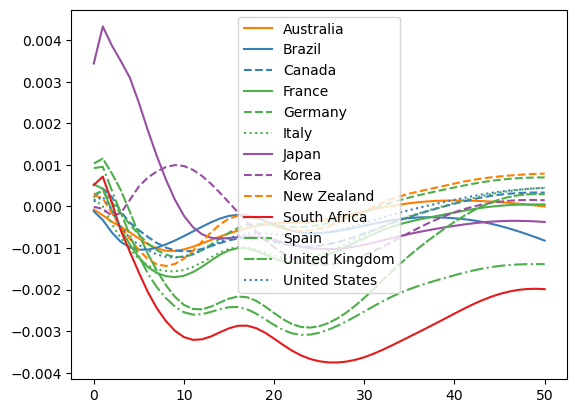

In [97]:
# Define the country and variable of the shock
country_shock = "Japan"
variable_shock = 'GDP'

# Define the countries and variables that should be in the IRF
new_country_list = np.array(['Brazil','Canada','United States','France','Germany','Italy','Spain','United Kingdom'])
country_choice = country_list
variable_choice = np.array(["GDP"])

# Define the length of h
max_h = 50

perform_GIRF(max_h,country_shock,variable_shock,country_choice,variable_choice)

In [83]:
# Calculate the inverse of G_0
G_0_inv = np.linalg.inv(create_G_j(j=0))

# Create a dictionary for the values of F_l
F_l_dict = {}

# Fill dictionary by computing the values of F_l 
for j in range(max_lag+1):
    F_l_dict[j] = G_0_inv @ create_G_j(j=j)

In [654]:
df_country = pd.concat([-x_it.shift(1),-x_star.shift(1)] ,axis=1)
df_country @ aa

,0,1
1996-01-01,NaN,NaN
1996-02-01,-0.016663,-0.003612
1996-03-01,-0.013303,-0.001035
1996-04-01,-0.069879,-0.002354
1996-05-01,-0.069131,-0.001121
...,...,...
2022-08-01,-0.000861,0.001762
2022-09-01,0.090188,0.001199
2022-10-01,-0.010013,-0.000881
2022-11-01,-0.250747,-0.001013


In [627]:
aa = statsmodels.tsa.vector_ar.vecm.coint_johansen(x_it_star,det_order=-1,k_ar_diff=max_lag-1).evec[:,:2]